# IST 664: Final Project
## Bag of Words: Unigram Approach

### Importing All the Necessary Libraries

In [1]:
import nltk 
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set(style="darkgrid")
import re
from nltk import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.naive_bayes import GaussianNB ,MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC , LinearSVC #support vector Machine
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Importing True and Fake News Data Sets

In [2]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

### Checking The Shape and Attributes of Both the Data Sets

In [3]:
df_true.describe().transpose()

,count,unique,top,freq
title,21417,20826,Factbox: Trump fills top jobs for his administ...,14
text,21417,21192,(Reuters) - Highlights for U.S. President Dona...,8
subject,21417,2,politicsNews,11272
date,21417,716,"December 20, 2017",182


In [4]:
df_fake.describe().transpose()

,count,unique,top,freq
title,23481,17903,MEDIA IGNORES Time That Bill Clinton FIRED His...,6
text,23481,17455,,626
subject,23481,6,News,9050
date,23481,1681,"May 10, 2017",46


### Adding a Column in Both Dataframe: True [1] or Fake News [0]
#### This column will be the target variable.

In [5]:
df_true['News'] = 1
df_fake['News'] = 0

### Combining Both Data Sets

In [6]:
df_combine = pd.concat([df_true, df_fake]).reset_index(drop = True)

### Dropping Unnecessary Columns
#### Dropping subject and date column as we don't need them for this project.

In [7]:
df_combine.drop(['subject', 'date'], axis = 1, inplace = True )

### Shuffle the Documents, So That Data Set is a Mixture of True and Fake News

In [9]:
df_combine = shuffle(df_combine, random_state = 43)

### Checking the shuffled data set.

In [10]:
df_combine.head(10)

,title,text,News
31481,WATCH KARMA IN ACTION: CNN GETS HIT With Tear ...,The timing couldn t have been better. Just as ...,0
25743,Rudy Giuliani’s Daughter Announces She’s Back...,Trump s biggest (and most insane) surrogate Ru...,0
12048,Philippines says Maoist rebels attacked soldie...,MANILA (Reuters) - Maoist rebels attacked sold...,1
17015,Fragment of Florence basilica falls and kills ...,"FLORENCE, Italy (Reuters) - A stone fragment, ...",1
9241,Sanders plants seeds for a lasting U.S. progre...,WASHINGTON (Reuters) - Bernie Sanders’ upstart...,1
1296,U.S. Attorney General Sessions urges crackdown...,"FALLS CHURCH, Va., (Reuters) - U.S. Attorney ...",1
43781,Dyer: ‘LA Times ‘Fake News’ Article is an Atta...,Jay Dyer 21st Century WireAccording to a recen...,0
44679,Boiler Room EP #74 – Dustification & The Crook...,Tune in to the Alternate Current Radio Network...,0
12472,Make EU gentleman's agreement with Britain bin...,BRUSSELS (Reuters) - The European Parliament w...,1
31823,BREAKING NEWS: OBAMA’S AG Loretta Lynch Ordere...,Is anyone really shocked that another fake Tr...,0


## Text Pre-Processing
#### This cell contains all the techniques that we have used for cleaning the textual data. Adding to that we also tokenize the words.

In [11]:
title_list = df_combine['title'].to_list()
text_list = df_combine['text'].to_list()

#Replacing '\n' Character or Multiple White Spaces With Single White Space.
spaces = re.compile("\s+")
for item in title_list:
    item.replace('\n', ' ')
    spaces.sub(" ", item)    
for item in text_list:
    item.replace('\n', ' ')
    spaces.sub(" ", item)

#Word Tokenization
title_list = [nltk.word_tokenize(item) for item in title_list]
text_list = [nltk.word_tokenize(item) for item in text_list]

#Lower Case
title_lower = []
for item in title_list:
    lower_words = [w.lower() for w in item]
    title_lower.append(lower_words)
text_lower = []
for item in text_list:
    lower_words = [w.lower() for w in item]
    text_lower.append(lower_words)

#Removing Punctuation and Special Characters
#Defining a function that identifies words without alphabets
def alpha_filter(w):
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False    
#Filtering out the words without any alphabet    
title_filter = []
for item in title_lower:
    filter_words = [w for w in item if not alpha_filter(w)]
    title_filter.append(filter_words)    
text_filter = []
for item in text_lower:
    filter_words = [w for w in item if not alpha_filter(w)]
    text_filter.append(filter_words)

#Removing Stopwords
stopwords = nltk.corpus.stopwords.words('english')
morestopwords = ['could','would','might','must','need','sha','wo','y',"'s","'d","'ll","'t","'m","'re","'ve", "n't", "let", "also", "shall"]
stopwords = stopwords + morestopwords
#Filtering out the stop words    
title_stop = []
for item in title_filter:
    stop_words = [w for w in item if not w in stopwords]
    title_stop.append(stop_words)    
text_stop = []
for item in text_filter:
    stop_words = [w for w in item if not w in stopwords]
    text_stop.append(stop_words)

### Combining into a New DataFrame and then Making a Train-Test Split.

In [12]:
target_df = pd.DataFrame(df_combine.News)

processed_df = pd.DataFrame(list(zip(title_stop, text_stop)), columns =['Title', 'Text'])

x_train, x_test, y_train, y_test = train_test_split(processed_df, target_df, test_size=0.30, random_state=73)

### Most Important Words as Features
#### This next cell gives us the most frequent words. Based on the necessity and available RAM, we choose 500 words from title column and 1000 words from text column.

In [13]:
train_title = x_train['Title'].to_list()
train_text = x_train['Text'].to_list()

#Flattenning the Lists
title_flat = [item for file in train_title for item in file]
text_flat = [item for file in train_text for item in file]

#Unigram Normalized Frequency: Top Frequent Words
#Generating Dictionary of Words and their frequency
fdist_title = FreqDist(title_flat)
fdist_text = FreqDist(text_flat)

#Selecting top words with respect to their frequency
topkeys_title = fdist_title.most_common(500)
topkeys_text = fdist_text.most_common(1000)

#Creating lists of top words only
title_features = []
for pair in topkeys_title:
    title_features.append(pair[0])
text_features = []
for pair in topkeys_text:
    text_features.append(pair[0])

### Features Extraction - Function
#### In this next cell we define a function that will return a dataframe will features as columns and every cell as a binary value representing the presence of given word in corresponding document.

In [14]:
def featureGenerator(title_list_1, text_list_2, title_words, text_words):

    #Creating a list of dictionaries where number of dictionaries is the number of words we selected as our top words.
    def document_features(document, word_features):
        document_words = set(document)
        features = {}
        for word in word_features:
            if word in document_words:
                features['V_{}'.format(word)] = 1
            else:
                features['V_{}'.format(word)] = 0
        return features

    #Define the feature sets for the documents.
    title_set_1 = []
    for d in title_list_1:
        title_set_1.append(document_features(d,title_words))
    text_set_2 = []
    for d in text_list_2:
        text_set_2.append(document_features(d,text_words))

    title_pd = pd.DataFrame(title_set_1)
    text_pd = pd.DataFrame(text_set_2)
    features_pd = pd.concat([title_pd, text_pd], axis=1)

    return features_pd

### Training and Testing Feature Sets

In [15]:
test_title = x_test['Title'].to_list()
test_text = x_test['Text'].to_list()

train_pd = featureGenerator(train_title, train_text, title_features, text_features)
test_pd = featureGenerator(test_title, test_text, title_features, text_features)

## Machine Learning Models
### 1. Logistic Regression
#### Fitting the baseline logit model over the training dataset.

In [16]:
from sklearn.linear_model import LogisticRegression

logit_R = LogisticRegression().fit(train_pd, y_train)

#### Using the baseline model, making the predictions on the test data and running the classification report.
#### Classification report gives us precision, recall, f1-measure and respective accuracies for the given classification task. 

In [17]:
predicted_values = logit_R.predict(test_pd)
print(classification_report(y_test, predicted_values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7051
           1       1.00      1.00      1.00      6419

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



### Feature Importance: Logistic Regression
#### Finding the words (unigrams) that affects the predictions the most.

In [18]:
cols = train_pd.columns
w = pd.DataFrame(list(zip(cols, [x for x in logit_R.coef_.tolist()[0]])),
            columns = ['feature','LR']).sort_values('LR',ascending=False)

w

,feature,LR
508,V_reuters,9.299588
2,V_u.s.,1.094678
3,V_says,1.019739
509,V_donald,1.016845
98,V_factbox,0.945713
...,...,...
512,V_obama,-1.167211
598,V_image,-1.799763
1,V_video,-2.078767
579,V_via,-2.227045


### Dropping Most Important Column
#### We observe that reuters word is way more effective than any other word in predicting. This might lead to overfitting of the model. Hence, we delete that variable.

In [19]:
train_pd = train_pd.drop(['V_reuters'], axis = 1)
test_pd = test_pd.drop(['V_reuters'], axis = 1)

### Logistic Regression with Grid Search and Cross Validation
#### Fine tuning the regularization parameters.
#### Cross valiation will help in variety of test dataset. (test of generalization)

In [20]:
param_grid_logit = {'C':[0.01,0.1,1],'penalty':['l1','l2'],
                 'solver':['newton-cg', 'lbfgs', 'liblinear'],
                 'warm_start':[True,False]}

grid_logit = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_logit, scoring='accuracy',
                       verbose=4,n_jobs=-1)

grid_logit.fit(train_pd, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=4)

#### Extracting the best regularization parameters.

In [21]:
grid_logit.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}

#### Extracting the best accuracy score from the cross validator.

In [22]:
grid_logit.best_score_

0.9845996368791654

#### Using the parameters building a tuned logistic regression model.

In [23]:
lg_tuned = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg')
lg_tuned.fit(train_pd, y_train)
lg_tuned_pred = lg_tuned.predict(test_pd)

#### Building a confusion matrix which returns the true positive, false positive, true negative and false negative values.

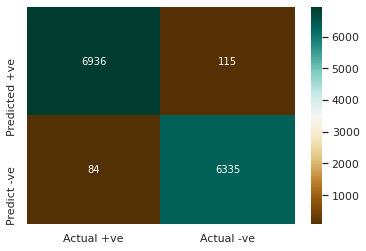

In [24]:
cfm = confusion_matrix(y_test, lg_tuned_pred)

df_cfm = pd.DataFrame(data=cfm, columns=['Actual +ve', 'Actual -ve'], 
                                 index=['Predicted +ve', 'Predict -ve'])
plot_cfm = sns.heatmap(df_cfm, annot=True, fmt='d', cmap='BrBG')

#### Running a classification report over the predictions.

In [25]:
print(classification_report(y_test, lg_tuned_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7051
           1       0.98      0.99      0.98      6419

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



### 2. Naive-Bayes Classifier
#### Fitting the baseline model over the training dataset.


In [26]:
nbc = GaussianNB(priors=None, var_smoothing = 1e-09)
nbc.fit(train_pd, y_train)
nbc_pred = nbc.predict(test_pd)

#### Running a classification report over the predictions.

In [27]:
print(classification_report(y_test, nbc_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7051
           1       0.93      0.93      0.93      6419

    accuracy                           0.94     13470
   macro avg       0.94      0.93      0.94     13470
weighted avg       0.94      0.94      0.94     13470



#### Building a confusion matrix which returns the true positive, false positive, true negative and false negative values.

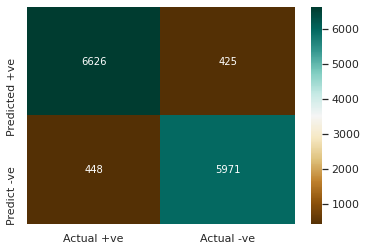

In [28]:
cfm = confusion_matrix(y_test, nbc_pred)

df_cfm = pd.DataFrame(data=cfm, columns=['Actual +ve', 'Actual -ve'], 
                                 index=['Predicted +ve', 'Predict -ve'])
plot_cfm = sns.heatmap(df_cfm, annot=True, fmt='d', cmap='BrBG')

### 3. Random Forest Classifier
#### Fitting the baseline model over the training dataset.

In [29]:
rf = RandomForestClassifier()
rf.fit(train_pd, y_train)
rf_pred = rf.predict(test_pd)

#### Running a classification report over the predictions.

In [30]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7051
           1       0.99      0.99      0.99      6419

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



#### Fine tuning the hyperparameters and performing cross validation.

In [31]:
param_grid_rf = { 'criterion': ['gini', 'entropy'],
                   'min_samples_leaf': [6],
                   'min_samples_split': [10],
                   'max_depth': [5, 10, 15],
                   'max_features': ['auto'],
                   'n_estimators': [200, 400, 600]}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs= -1, verbose = 2)
grid_rf.fit(train_pd, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 13.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

#### Extracting the best values of hyperparameters for the model.

In [32]:
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 600}

#### Extracting the best accuracy score out of the cross validator.

In [33]:
grid_rf.best_score_

0.9684676085019728

#### Finding the best model from the cross validator and making predictions over the test data set.

In [36]:
rf_tuned = grid_rf.best_estimator_
rf_tuned_pred = rf_tuned.predict(test_pd)

#### Running a classification report over the predictions.

In [37]:
print(classification_report(y_test, rf_tuned_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7051
           1       0.96      0.98      0.97      6419

    accuracy                           0.97     13470
   macro avg       0.97      0.97      0.97     13470
weighted avg       0.97      0.97      0.97     13470



### END OF PROJECT